# Lezione 14 — Alberi Decisionali e Random Forest

## 📍 Posizione nel Percorso
| Lezione | Argomento |
|---------|-----------|
| 11 | Validazione dei Modelli |
| 12 | Overfitting e Underfitting |
| 13 | Pipeline di Scikit-Learn |
| **14** | **Alberi Decisionali e Random Forest** ← Sei qui |
| 15 | Gradient Boosting (XGBoost, LightGBM) |

## 🎯 Obiettivi della Lezione
1. Capire come funziona un **Decision Tree**
2. Conoscere i criteri di split: **Gini** vs **Entropy**
3. Capire il concetto di **Ensemble** e **Bagging**
4. Usare **Random Forest** per classificazione e regressione
5. Estrarre e interpretare la **Feature Importance**

## 📚 Librerie utilizzate
```python
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
```

# Section 1 — Decision Tree: Come Funziona

## L'Intuizione

Un **albero decisionale** fa esattamente quello che farebbe un essere umano:
pone una serie di domande binarie (sì/no) per arrivare a una decisione.

```
                    [Età > 30?]
                    /         \
                  Sì           No
                  /             \
         [Reddito > 50k?]    [Studente?]
           /        \          /      \
         Sì          No      Sì        No
         /            \      /          \
    [APPROVA]    [NEGA]  [APPROVA]   [NEGA]
```

## Componenti dell'Albero

| Termine | Descrizione |
|---------|-------------|
| **Nodo radice** (root) | Primo split, in cima all'albero |
| **Nodo interno** | Un punto di decisione (feature + threshold) |
| **Foglia** (leaf) | Nodo terminale con la predizione finale |
| **Ramo** (branch) | Connessione tra nodi (sì/no) |
| **Profondità** (depth) | Numero massimo di split dalla radice alla foglia |

## Come Sceglie lo Split?

L'albero cerca lo split che **massimizza la separazione** delle classi.
Ogni split deve rendere i sottogruppi più "puri" possibile.

### Criteri di Impurità

**1. Gini Impurity** (default in sklearn):
$$Gini = 1 - \sum_{i=1}^{C} p_i^2$$

- Se tutte le classi sono uguali: $Gini = 0$ (puro)
- Se le classi sono bilanciate 50/50: $Gini = 0.5$ (massima impurità)

**2. Entropy** (Information Gain):
$$Entropy = -\sum_{i=1}^{C} p_i \log_2(p_i)$$

- Se tutte le classi sono uguali: $Entropy = 0$ (puro)
- Se le classi sono bilanciate 50/50: $Entropy = 1$ (massima impurità)

### Gini vs Entropy

| Aspetto | Gini | Entropy |
|---------|------|---------|
| **Velocità** | Più veloce (no logaritmo) | Leggermente più lento |
| **Risultati** | Quasi identici | Quasi identici |
| **Default sklearn** | ✅ Sì | No |
| **Uso tipico** | Classificazione | Quando serve interpretabilità teorica |

> **In pratica**: usa Gini (default). La differenza è minima.

DECISION TREE SENZA LIMITI
Profondità: 6
Numero foglie: 16
Train Accuracy: 1.0000
Test Accuracy: 0.9200
⚠️  Train 100% → probabile overfitting!

DECISION TREE CON LIMITI (max_depth=3)
Profondità: 3
Numero foglie: 7
Train Accuracy: 0.9400
Test Accuracy: 0.9200
✅ Migliore generalizzazione!


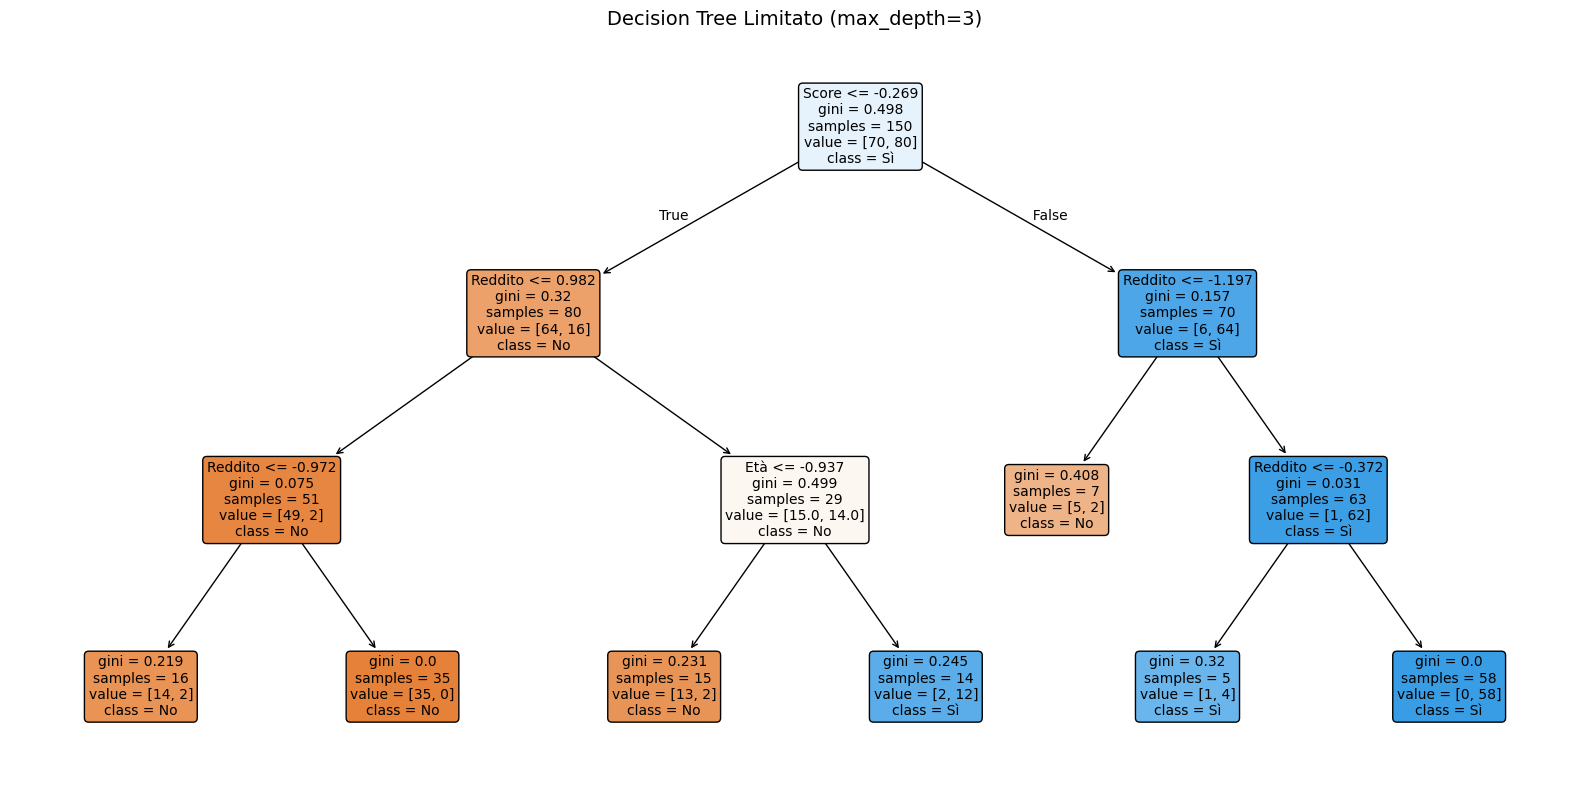


📖 Come leggere l'albero:
   - gini: impurità del nodo (0 = puro)
   - samples: quanti campioni arrivano a quel nodo
   - value: [classe_0, classe_1]
   - class: predizione se il nodo fosse una foglia


In [1]:
# Dimostrazione: Decision Tree - Visualizzazione e Interpretazione

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Dataset semplice per visualizzazione
np.random.seed(42)
X, y = make_classification(
    n_samples=200,
    n_features=4,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

# Nomi features per leggibilità
feature_names = ['Età', 'Reddito', 'Score', 'Anzianità']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ============================================================================
# Albero SENZA limiti (overfitting garantito)
# ============================================================================
tree_unlimited = DecisionTreeClassifier(random_state=42)
tree_unlimited.fit(X_train, y_train)

print("="*60)
print("DECISION TREE SENZA LIMITI")
print("="*60)
print(f"Profondità: {tree_unlimited.get_depth()}")
print(f"Numero foglie: {tree_unlimited.get_n_leaves()}")
print(f"Train Accuracy: {tree_unlimited.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {tree_unlimited.score(X_test, y_test):.4f}")
print("⚠️  Train 100% → probabile overfitting!")

# ============================================================================
# Albero CON limiti (regularizzato)
# ============================================================================
tree_limited = DecisionTreeClassifier(
    max_depth=3,           # profondità massima
    min_samples_split=10,  # minimo campioni per fare uno split
    min_samples_leaf=5,    # minimo campioni in ogni foglia
    random_state=42
)
tree_limited.fit(X_train, y_train)

print(f"\n{'='*60}")
print("DECISION TREE CON LIMITI (max_depth=3)")
print("="*60)
print(f"Profondità: {tree_limited.get_depth()}")
print(f"Numero foglie: {tree_limited.get_n_leaves()}")
print(f"Train Accuracy: {tree_limited.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {tree_limited.score(X_test, y_test):.4f}")
print("✅ Migliore generalizzazione!")

# ============================================================================
# Visualizzazione dell'albero
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 8))
plot_tree(
    tree_limited,
    feature_names=feature_names,
    class_names=['No', 'Sì'],
    filled=True,
    rounded=True,
    ax=ax,
    fontsize=10
)
plt.title("Decision Tree Limitato (max_depth=3)", fontsize=14)
plt.tight_layout()
plt.show()

print("\n📖 Come leggere l'albero:")
print("   - gini: impurità del nodo (0 = puro)")
print("   - samples: quanti campioni arrivano a quel nodo")
print("   - value: [classe_0, classe_1]")
print("   - class: predizione se il nodo fosse una foglia")

# Section 2 — Il Problema: Alberi Singoli sono Instabili

## Limiti del Decision Tree

| Problema | Descrizione |
|----------|-------------|
| **Alta varianza** | Piccoli cambiamenti nei dati → alberi molto diversi |
| **Overfitting** | Senza limiti, memorizza il training set |
| **Decision boundaries rettangolari** | Può essere poco efficiente per dati complessi |
| **Instabilità** | Rimuovere pochi campioni può cambiare tutto l'albero |

## La Soluzione: Ensemble Methods

> **Idea**: Combinare tanti modelli "deboli" per ottenerne uno "forte"

### Tipi di Ensemble

```
ENSEMBLE METHODS
├── BAGGING (Bootstrap Aggregating)
│   └── Random Forest ← questa lezione
│
├── BOOSTING (sequenziale)
│   ├── AdaBoost
│   ├── Gradient Boosting
│   ├── XGBoost
│   └── LightGBM ← prossima lezione
│
└── STACKING (meta-learning)
    └── Combina predizioni di modelli diversi
```

## Bagging: L'Idea

1. Crea **N campioni bootstrap** (con replacement) dal training set
2. Addestra **N alberi indipendenti** su questi campioni
3. **Combina le predizioni**:
   - Classificazione → voto di maggioranza
   - Regressione → media delle predizioni

```
Dataset Originale
       │
       ▼
┌──────┴──────┐
│  Bootstrap  │ (campionamento con replacement)
└──────┬──────┘
       │
    ┌──┴──┬──────┬──────┐
    ▼     ▼      ▼      ▼
  Tree₁ Tree₂  Tree₃  Tree_N
    │     │      │      │
    └──┬──┴──────┴──────┘
       │
       ▼
   VOTO/MEDIA
       │
       ▼
  Predizione Finale
```

# Section 3 — Random Forest

## Cos'è Random Forest?

Random Forest = **Bagging** + **Feature Randomization**

Oltre al campionamento bootstrap, ogni albero considera solo un **sottoinsieme casuale di features** ad ogni split.

### Perché la randomizzazione delle features?

Senza: tutti gli alberi userebbero le stesse features importanti → alberi correlati → poco vantaggio

Con: ogni albero è diverso → meno correlazione → ensemble più robusto

## Iperparametri Chiave

| Parametro | Default | Descrizione |
|-----------|---------|-------------|
| `n_estimators` | 100 | Numero di alberi |
| `max_depth` | None | Profondità massima (None = illimitata) |
| `min_samples_split` | 2 | Minimo campioni per split |
| `min_samples_leaf` | 1 | Minimo campioni per foglia |
| `max_features` | 'sqrt' | Features considerate per split |
| `bootstrap` | True | Usare campionamento bootstrap |
| `oob_score` | False | Calcolare Out-of-Bag score |
| `n_jobs` | None | Parallelizzazione (-1 = tutti i core) |
| `random_state` | None | Riproducibilità |

### max_features: Regola Pratica

| Task | max_features consigliato |
|------|-------------------------|
| Classificazione | `'sqrt'` (√n_features) |
| Regressione | `1.0` o `'log2'` |

## Out-of-Bag (OOB) Score

Con bootstrap, circa il 37% dei campioni **non** viene usato per ogni albero.
Questi campioni "out-of-bag" possono essere usati come **validation set gratuito**!

```python
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, y)
print(rf.oob_score_)  # Stima dell'accuracy senza CV!
```

CONFRONTO: Decision Tree vs Random Forest
Dataset: 1000 campioni, 20 features

📊 DECISION TREE:
   Train Accuracy: 1.0000
   Test Accuracy:  0.7720
   CV Accuracy:    0.7680
   Gap train-test: 0.2280

🌲 RANDOM FOREST (100 alberi):
   Train Accuracy: 1.0000
   Test Accuracy:  0.8640
   CV Accuracy:    0.8730
   OOB Score:      0.8627
   Gap train-test: 0.1360

RISULTATO:
Random Forest migliora il test accuracy di: +0.0920
Random Forest ha un gap train-test più piccolo: meno overfitting!

EFFETTO DEL NUMERO DI ALBERI
     1 alberi → Test Accuracy: 0.6680
     5 alberi → Test Accuracy: 0.8120
    10 alberi → Test Accuracy: 0.8400
    25 alberi → Test Accuracy: 0.8720
    50 alberi → Test Accuracy: 0.8640
   100 alberi → Test Accuracy: 0.8640
   200 alberi → Test Accuracy: 0.8720


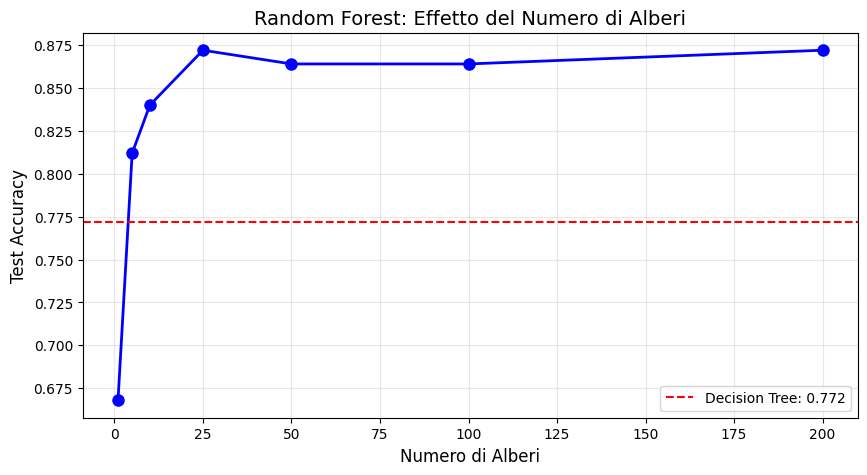


✅ Più alberi = risultato più stabile (ma rendimenti decrescenti dopo ~100)


In [2]:
# Dimostrazione: Random Forest vs Decision Tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
import numpy as np

# Dataset più complesso
np.random.seed(42)
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    flip_y=0.1,  # 10% rumore
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("="*60)
print("CONFRONTO: Decision Tree vs Random Forest")
print("="*60)
print(f"Dataset: {X.shape[0]} campioni, {X.shape[1]} features")

# ============================================================================
# Decision Tree
# ============================================================================
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

dt_train = dt.score(X_train, y_train)
dt_test = dt.score(X_test, y_test)
dt_cv = cross_val_score(dt, X, y, cv=5).mean()

print(f"\n📊 DECISION TREE:")
print(f"   Train Accuracy: {dt_train:.4f}")
print(f"   Test Accuracy:  {dt_test:.4f}")
print(f"   CV Accuracy:    {dt_cv:.4f}")
print(f"   Gap train-test: {dt_train - dt_test:.4f}")

# ============================================================================
# Random Forest
# ============================================================================
rf = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)
rf_cv = cross_val_score(rf, X, y, cv=5).mean()

print(f"\n🌲 RANDOM FOREST (100 alberi):")
print(f"   Train Accuracy: {rf_train:.4f}")
print(f"   Test Accuracy:  {rf_test:.4f}")
print(f"   CV Accuracy:    {rf_cv:.4f}")
print(f"   OOB Score:      {rf.oob_score_:.4f}")
print(f"   Gap train-test: {rf_train - rf_test:.4f}")

# ============================================================================
# Confronto
# ============================================================================
print(f"\n{'='*60}")
print("RISULTATO:")
print(f"{'='*60}")
improvement = rf_test - dt_test
print(f"Random Forest migliora il test accuracy di: +{improvement:.4f}")
print(f"Random Forest ha un gap train-test più piccolo: meno overfitting!")

# Effetto del numero di alberi
print(f"\n{'='*60}")
print("EFFETTO DEL NUMERO DI ALBERI")
print("="*60)

n_trees_list = [1, 5, 10, 25, 50, 100, 200]
results = []

for n_trees in n_trees_list:
    rf_temp = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    test_acc = rf_temp.score(X_test, y_test)
    results.append(test_acc)
    print(f"   {n_trees:3d} alberi → Test Accuracy: {test_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(n_trees_list, results, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=dt_test, color='r', linestyle='--', label=f'Decision Tree: {dt_test:.3f}')
plt.xlabel('Numero di Alberi', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Random Forest: Effetto del Numero di Alberi', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ Più alberi = risultato più stabile (ma rendimenti decrescenti dopo ~100)")

# Section 4 — Feature Importance

## Perché è Importante?

La **Feature Importance** ci dice quali variabili sono più utili per le predizioni.

Questo serve per:
- **Interpretare** il modello
- **Ridurre** le features (feature selection)
- **Comunicare** i risultati agli stakeholder
- **Validare** che il modello usi le features "giuste"

## Come si Calcola?

### 1. Mean Decrease in Impurity (MDI) — Default in sklearn

Per ogni feature, somma la riduzione di impurità (Gini/Entropy) causata da tutti gli split su quella feature, pesata per il numero di campioni.

```python
rf.feature_importances_  # Array di importanze (somma = 1)
```

**Pro**: Veloce, già calcolato
**Contro**: Può favorire features con molti valori unici

### 2. Permutation Importance — Più affidabile

1. Calcola la metrica sul test set
2. Per ogni feature: mescola i valori casualmente
3. Ricalcola la metrica
4. Importanza = calo della metrica

```python
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10)
result.importances_mean  # Importanze medie
```

**Pro**: Non favorisce features con molti valori
**Contro**: Più lento (richiede ripetute predizioni)

## Regola Pratica

| Situazione | Usa |
|------------|-----|
| Esplorazione veloce | `feature_importances_` (MDI) |
| Report finale | Permutation Importance |
| Features correlate | Attenzione: importanza condivisa!

FEATURE IMPORTANCE
Test Accuracy: 0.7440

METODO 1: Mean Decrease in Impurity (built-in)
        feature  importance
        reddito    0.270283
   debito_ratio    0.267204
       rumore_2    0.105947
    anni_lavoro    0.102613
       rumore_1    0.102038
            età    0.084851
n_carte_credito    0.051916
          mutuo    0.015147

METODO 2: Permutation Importance (più affidabile)
        feature  importance_mean  importance_std
   debito_ratio           0.1520        0.028171
        reddito           0.0792        0.042097
       rumore_2           0.0240        0.019596
n_carte_credito           0.0160        0.020552
            età           0.0120        0.026107
    anni_lavoro           0.0016        0.016317
          mutuo           0.0000        0.008000
       rumore_1          -0.0184        0.018260


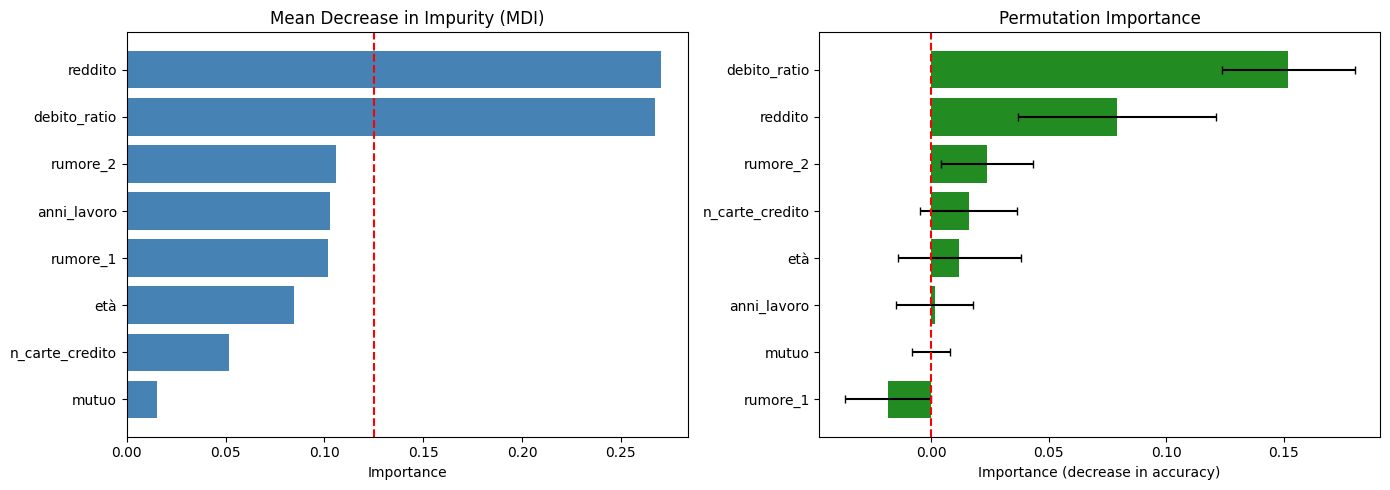


📖 Interpretazione:
   - Le features 'rumore_1' e 'rumore_2' hanno importanza ~0 (corretto!)
   - 'debito_ratio' e 'reddito' sono le più importanti (come atteso)
   - Permutation Importance mostra anche l'incertezza (barre errore)


In [3]:
# Dimostrazione: Feature Importance

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

# Creiamo un dataset con nomi features interpretabili
np.random.seed(42)
n_samples = 500

# Simuliamo un dataset di credito
df_credit = pd.DataFrame({
    'reddito': np.random.normal(50000, 15000, n_samples),
    'età': np.random.randint(22, 65, n_samples),
    'debito_ratio': np.random.uniform(0.1, 0.8, n_samples),
    'anni_lavoro': np.random.randint(0, 30, n_samples),
    'n_carte_credito': np.random.randint(0, 8, n_samples),
    'mutuo': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
    'rumore_1': np.random.randn(n_samples),  # feature inutile
    'rumore_2': np.random.randn(n_samples),  # feature inutile
})

# Target: approvazione prestito (correlato a reddito, debito_ratio, anni_lavoro)
prob = (
    0.3 
    + 0.4 * (df_credit['reddito'] > 45000)
    - 0.5 * (df_credit['debito_ratio'] > 0.5)
    + 0.2 * (df_credit['anni_lavoro'] > 5)
)
df_credit['approvato'] = (np.random.random(n_samples) < prob.clip(0.1, 0.9)).astype(int)

X = df_credit.drop('approvato', axis=1)
y = df_credit['approvato']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("="*60)
print("FEATURE IMPORTANCE")
print("="*60)
print(f"Test Accuracy: {rf.score(X_test, y_test):.4f}")

# ============================================================================
# Metodo 1: Mean Decrease in Impurity (MDI)
# ============================================================================
print(f"\n{'='*60}")
print("METODO 1: Mean Decrease in Impurity (built-in)")
print("="*60)

mdi_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(mdi_importance.to_string(index=False))

# ============================================================================
# Metodo 2: Permutation Importance
# ============================================================================
print(f"\n{'='*60}")
print("METODO 2: Permutation Importance (più affidabile)")
print("="*60)

perm_result = permutation_importance(
    rf, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values('importance_mean', ascending=False)

print(perm_importance.to_string(index=False))

# ============================================================================
# Visualizzazione comparativa
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MDI
ax1 = axes[0]
mdi_sorted = mdi_importance.sort_values('importance')
ax1.barh(mdi_sorted['feature'], mdi_sorted['importance'], color='steelblue')
ax1.set_xlabel('Importance')
ax1.set_title('Mean Decrease in Impurity (MDI)')
ax1.axvline(x=1/len(X.columns), color='red', linestyle='--', label='Random baseline')

# Permutation
ax2 = axes[1]
perm_sorted = perm_importance.sort_values('importance_mean')
ax2.barh(perm_sorted['feature'], perm_sorted['importance_mean'], 
         xerr=perm_sorted['importance_std'], color='forestgreen', capsize=3)
ax2.set_xlabel('Importance (decrease in accuracy)')
ax2.set_title('Permutation Importance')
ax2.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

print("\n📖 Interpretazione:")
print("   - Le features 'rumore_1' e 'rumore_2' hanno importanza ~0 (corretto!)")
print("   - 'debito_ratio' e 'reddito' sono le più importanti (come atteso)")
print("   - Permutation Importance mostra anche l'incertezza (barre errore)")

# Section 5 — Schema Mentale: Quando Usare Tree-Based Models

## Checklist Decisionale

### ✅ USA Decision Tree / Random Forest quando:

| Situazione | Motivo |
|------------|--------|
| **Interpretabilità** importante | Gli alberi sono spiegabili |
| **Dati misti** (numerici + categorici) | Gestiscono tutto nativamente |
| **Non-linearità** nei dati | Catturano relazioni complesse |
| **Interazioni** tra features | Le scoprono automaticamente |
| **Outliers** presenti | Robusti agli outlier |
| **No scaling** richiesto | Non serve normalizzare |
| **Baseline veloce** | Random Forest è un ottimo punto di partenza |

### ⚠️ ATTENZIONE quando:

| Situazione | Problema |
|------------|----------|
| **Dati molto high-dimensional** | Meglio boosting o modelli lineari |
| **Relazioni lineari** semplici | Un modello lineare è più efficiente |
| **Estrapolazione** necessaria | Gli alberi non estrapolano oltre i dati visti |
| **Dataset molto piccolo** | Rischio overfitting anche con RF |

## Confronto Rapido

| Modello | Interpretabilità | Performance | Velocità Training | Overfitting |
|---------|-----------------|-------------|------------------|-------------|
| Decision Tree | ⭐⭐⭐⭐⭐ | ⭐⭐ | ⭐⭐⭐⭐⭐ | Alto |
| Random Forest | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐ | Basso |
| Gradient Boosting | ⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐ | Medio |

## Regola d'Oro

> **"Inizia sempre con Random Forest come baseline. È difficile fare meglio senza molto tuning."**

```
WORKFLOW TIPICO:
1. Random Forest (baseline)
2. Se serve più performance → Gradient Boosting (XGBoost/LightGBM)
3. Se serve interpretabilità → Decision Tree singolo + SHAP values
```

# Section 6 — Esercizi Svolti

---

## 🎯 Esercizio 14.1 — Confronto Decision Tree con Diversi max_depth

**Obiettivo**: Studiare l'effetto di max_depth su overfitting/underfitting.

**Consegna**:
1. Genera un dataset con `make_classification` (500 campioni, 15 features)
2. Testa Decision Tree con max_depth = [1, 2, 3, 5, 10, 20, None]
3. Calcola train e test accuracy per ogni configurazione
4. Trova il max_depth ottimale
5. Visualizza i risultati con un grafico

ESERCIZIO 14.1 — Effetto di max_depth
1. Dataset: (500, 15)

2-3. Test diversi max_depth:
 max_depth |  Train Acc |   Test Acc |      Gap
---------------------------------------------
         1 |     0.7440 |     0.7360 |   0.0080
         2 |     0.7813 |     0.7520 |   0.0293
         3 |     0.8880 |     0.8240 |   0.0640
         5 |     0.9493 |     0.8320 |   0.1173
        10 |     1.0000 |     0.8240 |   0.1760
        20 |     1.0000 |     0.8240 |   0.1760
      None |     1.0000 |     0.8240 |   0.1760

4. Max_depth ottimale: 5
   Miglior Test Accuracy: 0.8320


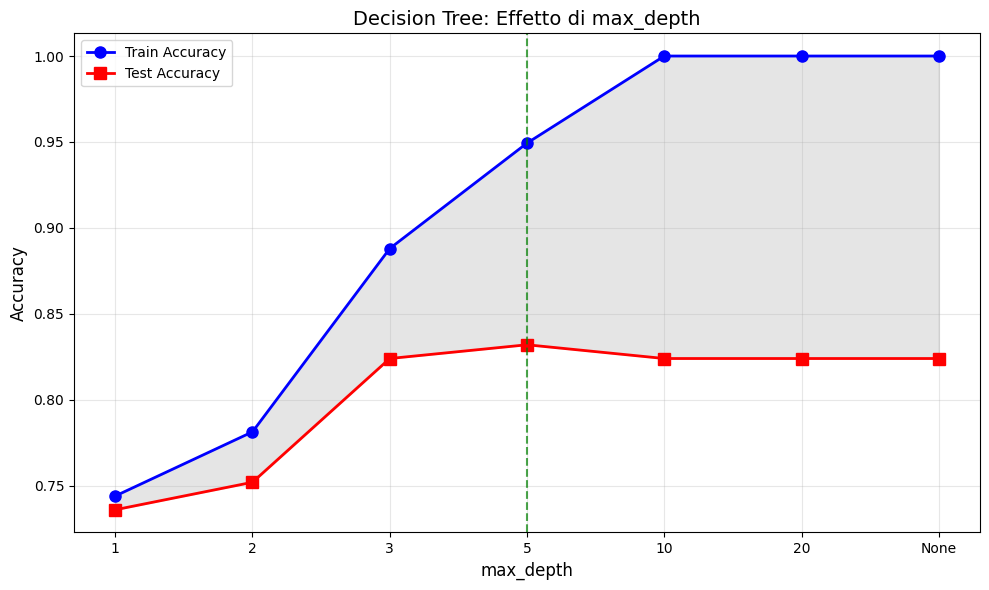


5. Grafico generato!

📖 Interpretazione:
   - max_depth basso → underfitting (train e test bassi)
   - max_depth alto/None → overfitting (train alto, test cala)
   - max_depth=5 → miglior bilanciamento


In [4]:
# ============================================================================
# SOLUZIONE ESERCIZIO 14.1 — Confronto Decision Tree con Diversi max_depth
# ============================================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("ESERCIZIO 14.1 — Effetto di max_depth")
print("="*60)

# 1. Genera dataset
np.random.seed(42)
X, y = make_classification(
    n_samples=500,
    n_features=15,
    n_informative=10,
    n_redundant=3,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"1. Dataset: {X.shape}")

# 2-3. Test diversi max_depth
max_depths = [1, 2, 3, 5, 10, 20, None]
results = []

print(f"\n2-3. Test diversi max_depth:")
print(f"{'max_depth':>10} | {'Train Acc':>10} | {'Test Acc':>10} | {'Gap':>8}")
print("-" * 45)

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    train_acc = dt.score(X_train, y_train)
    test_acc = dt.score(X_test, y_test)
    gap = train_acc - test_acc
    
    results.append({
        'max_depth': depth if depth else 'None',
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': gap
    })
    
    depth_str = str(depth) if depth else 'None'
    print(f"{depth_str:>10} | {train_acc:>10.4f} | {test_acc:>10.4f} | {gap:>8.4f}")

# 4. Trova max_depth ottimale
results_df = pd.DataFrame(results)
best_idx = results_df['test_acc'].idxmax()
best_depth = results_df.loc[best_idx, 'max_depth']
best_test_acc = results_df.loc[best_idx, 'test_acc']

print(f"\n4. Max_depth ottimale: {best_depth}")
print(f"   Miglior Test Accuracy: {best_test_acc:.4f}")

# 5. Visualizzazione
plt.figure(figsize=(10, 6))

# Convertiamo None in un numero per il plot
x_labels = [str(d) if d else 'None' for d in max_depths]
x_pos = range(len(max_depths))

plt.plot(x_pos, results_df['train_acc'], 'b-o', label='Train Accuracy', linewidth=2, markersize=8)
plt.plot(x_pos, results_df['test_acc'], 'r-s', label='Test Accuracy', linewidth=2, markersize=8)

plt.fill_between(x_pos, results_df['train_acc'], results_df['test_acc'], alpha=0.2, color='gray')

plt.xticks(x_pos, x_labels)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree: Effetto di max_depth', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Evidenzia il punto ottimale
plt.axvline(x=best_idx, color='green', linestyle='--', alpha=0.7, label='Ottimale')

plt.tight_layout()
plt.show()

print("\n5. Grafico generato!")
print("\n📖 Interpretazione:")
print("   - max_depth basso → underfitting (train e test bassi)")
print("   - max_depth alto/None → overfitting (train alto, test cala)")
print(f"   - max_depth={best_depth} → miglior bilanciamento")

---

## 🎯 Esercizio 14.2 — Random Forest per Regressione

**Obiettivo**: Usare RandomForestRegressor per predire un valore continuo.

**Consegna**:
1. Genera un dataset di regressione con `make_regression`
2. Addestra un RandomForestRegressor con 100 alberi
3. Calcola le metriche: MSE, RMSE, R²
4. Mostra le top 5 features più importanti
5. Confronta con un singolo DecisionTreeRegressor

ESERCIZIO 14.2 — Random Forest per Regressione
1. Dataset: (500, 12)

2. RandomForestRegressor con 100 alberi addestrato

3. Metriche Random Forest:
   MSE:  4778.4141
   RMSE: 69.1261
   R²:   0.7265

4. Top 5 Features più importanti:
   feature  importance
feature_11    0.532947
 feature_8    0.144008
 feature_5    0.069686
 feature_9    0.058701
 feature_6    0.051927

5. Confronto con Decision Tree:
Metrica    |   Random Forest |   Decision Tree
---------------------------------------------
MSE        |       4778.4141 |       7930.9304
RMSE       |         69.1261 |         89.0558
R²         |          0.7265 |          0.5461


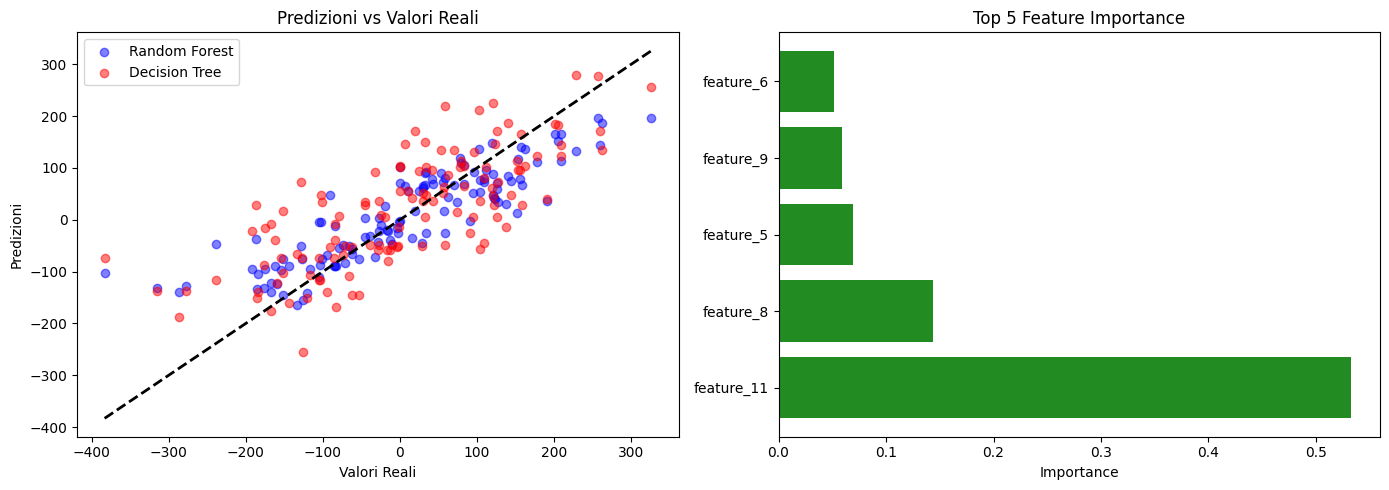


✅ Random Forest migliora R² di 0.1804 rispetto a Decision Tree!


In [5]:
# ============================================================================
# SOLUZIONE ESERCIZIO 14.2 — Random Forest per Regressione
# ============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("="*60)
print("ESERCIZIO 14.2 — Random Forest per Regressione")
print("="*60)

# 1. Genera dataset di regressione
np.random.seed(42)
X, y = make_regression(
    n_samples=500,
    n_features=12,
    n_informative=8,
    noise=20,
    random_state=42
)

# Nomi features
feature_names = [f'feature_{i}' for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"1. Dataset: {X.shape}")

# 2. Random Forest Regressor
rf_reg = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)

print(f"\n2. RandomForestRegressor con 100 alberi addestrato")

# 3. Metriche
y_pred_rf = rf_reg.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\n3. Metriche Random Forest:")
print(f"   MSE:  {mse_rf:.4f}")
print(f"   RMSE: {rmse_rf:.4f}")
print(f"   R²:   {r2_rf:.4f}")

# 4. Top 5 features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n4. Top 5 Features più importanti:")
print(importance_df.head().to_string(index=False))

# 5. Confronto con Decision Tree
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
y_pred_dt = dt_reg.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"\n5. Confronto con Decision Tree:")
print(f"{'Metrica':<10} | {'Random Forest':>15} | {'Decision Tree':>15}")
print("-" * 45)
print(f"{'MSE':<10} | {mse_rf:>15.4f} | {mse_dt:>15.4f}")
print(f"{'RMSE':<10} | {rmse_rf:>15.4f} | {rmse_dt:>15.4f}")
print(f"{'R²':<10} | {r2_rf:>15.4f} | {r2_dt:>15.4f}")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot predizioni
ax1 = axes[0]
ax1.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest', color='blue')
ax1.scatter(y_test, y_pred_dt, alpha=0.5, label='Decision Tree', color='red')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
ax1.set_xlabel('Valori Reali')
ax1.set_ylabel('Predizioni')
ax1.set_title('Predizioni vs Valori Reali')
ax1.legend()

# Feature importance
ax2 = axes[1]
top5 = importance_df.head()
ax2.barh(top5['feature'], top5['importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('Top 5 Feature Importance')

plt.tight_layout()
plt.show()

print(f"\n✅ Random Forest migliora R² di {r2_rf - r2_dt:.4f} rispetto a Decision Tree!")

---

## 🎯 Esercizio 14.3 — Random Forest con Hyperparameter Tuning

**Obiettivo**: Ottimizzare un Random Forest con GridSearchCV.

**Consegna**:
1. Crea un dataset di classificazione
2. Definisci una griglia: n_estimators, max_depth, min_samples_split
3. Usa GridSearchCV con 5-fold
4. Mostra i migliori parametri
5. Confronta score default vs ottimizzato

In [6]:
# ============================================================================
# SOLUZIONE ESERCIZIO 14.3 — Random Forest con Hyperparameter Tuning
# ============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
import numpy as np

print("="*60)
print("ESERCIZIO 14.3 — Random Forest con Hyperparameter Tuning")
print("="*60)

# 1. Dataset
np.random.seed(42)
X, y = make_classification(
    n_samples=600,
    n_features=15,
    n_informative=10,
    n_classes=2,
    flip_y=0.1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"1. Dataset: {X.shape}")

# 2. Griglia iperparametri
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n2. Griglia definita:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")
print(f"   Totale combinazioni: {n_combinations}")

# 3. GridSearchCV
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

print(f"\n3. GridSearchCV in corso ({n_combinations} × 5 fold = {n_combinations * 5} fit)...")
grid_search.fit(X_train, y_train)
print("   Completato!")

# 4. Migliori parametri
print(f"\n4. Migliori parametri:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"   Miglior CV Score: {grid_search.best_score_:.4f}")

# 5. Confronto default vs ottimizzato
rf_default = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_default.fit(X_train, y_train)

default_test = rf_default.score(X_test, y_test)
optimized_test = grid_search.score(X_test, y_test)

print(f"\n5. Confronto su Test Set:")
print(f"   {'Modello':<20} | {'Test Accuracy':>15}")
print("-" * 40)
print(f"   {'RF Default':<20} | {default_test:>15.4f}")
print(f"   {'RF Ottimizzato':<20} | {optimized_test:>15.4f}")
print(f"   {'Miglioramento':<20} | {optimized_test - default_test:>+15.4f}")

# Top 5 combinazioni
print(f"\n   Top 5 combinazioni:")
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values('rank_test_score')[['params', 'mean_test_score', 'std_test_score']].head()
for _, row in results.iterrows():
    print(f"   Score: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f} → {row['params']}")

print("\n✅ Hyperparameter tuning completato!")

ESERCIZIO 14.3 — Random Forest con Hyperparameter Tuning
1. Dataset: (600, 15)

2. Griglia definita:
   n_estimators: [50, 100, 200]
   max_depth: [5, 10, 20, None]
   min_samples_split: [2, 5, 10]
   Totale combinazioni: 36

3. GridSearchCV in corso (36 × 5 fold = 180 fit)...
   Completato!

4. Migliori parametri:
   max_depth: 10
   min_samples_split: 5
   n_estimators: 200
   Miglior CV Score: 0.8711

5. Confronto su Test Set:
   Modello              |   Test Accuracy
----------------------------------------
   RF Default           |          0.8667
   RF Ottimizzato       |          0.8733
   Miglioramento        |         +0.0067

   Top 5 combinazioni:
   Score: 0.8711 ± 0.0229 → {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
   Score: 0.8711 ± 0.0319 → {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
   Score: 0.8711 ± 0.0269 → {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
   Score: 0.8711 ± 0.0319 → {'max_depth': 20, 'min_samples

# Conclusione

## 🧠 Bignami — Alberi Decisionali e Random Forest

### Concetti Chiave

| Concetto | Descrizione |
|----------|-------------|
| **Decision Tree** | Modello che fa split binari per separare classi |
| **Gini Impurity** | Criterio di split (default): $1 - \sum p_i^2$ |
| **Entropy** | Criterio alternativo: $-\sum p_i \log_2(p_i)$ |
| **Bagging** | Bootstrap Aggregating: media di modelli su campioni diversi |
| **Random Forest** | Bagging + randomizzazione delle features |
| **Feature Importance** | Quanto ogni variabile contribuisce alle predizioni |
| **OOB Score** | Validazione "gratuita" sui campioni non usati |

### Sintassi Essenziale

```python
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
dt.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,     # numero alberi
    max_depth=10,         # profondità massima
    oob_score=True,       # out-of-bag validation
    n_jobs=-1             # parallelizzazione
)
rf.fit(X_train, y_train)
print(rf.oob_score_)      # OOB accuracy

# Feature importance
importance = rf.feature_importances_

# Permutation importance (più affidabile)
from sklearn.inspection import permutation_importance
perm = permutation_importance(rf, X_test, y_test, n_repeats=10)
```

### Iperparametri Importanti

| Parametro | Tipico Range | Effetto |
|-----------|--------------|---------|
| `n_estimators` | 100-500 | Più alberi = più stabile |
| `max_depth` | 5-20 o None | Controlla complessità |
| `min_samples_split` | 2-20 | Previene split su pochi dati |
| `max_features` | 'sqrt', 'log2' | Diversifica gli alberi |

### Decision Tree vs Random Forest

| Aspetto | Decision Tree | Random Forest |
|---------|--------------|---------------|
| Overfitting | ⚠️ Alto | ✅ Basso |
| Interpretabilità | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |
| Performance | ⭐⭐ | ⭐⭐⭐⭐ |
| Velocità training | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |

---

## 📚 Prossima Lezione

**Lezione 15**: Gradient Boosting (XGBoost, LightGBM)
- Boosting vs Bagging
- Come funziona Gradient Boosting
- XGBoost e LightGBM
- Tuning degli iperparametri